# Coursework 1
Objective: To become familiar with the image super-resolution problem setting.

In [1]:
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import tensorflow as tf
import scipy
from  scipy import ndimage, misc
import pdb
import imageio
import skimage
from PIL import Image

## The questions to think over:

**1. What are the concepts of image size and image resolution?**<br>
Image size and resolution are both refer to the number of pixels in an image. 

**2. What is gray-scale or single-channel image super-resolution?**<br>
Grey-scale image is one in which the value of each pixel is a single sample representing only an amount of light, it carries only intensity information. Super-resolution means enhancing the resolution of an imaging system.

**3. What is Ground Truth image?**<br>
Ground truth means image that is known to be much more accurate than image from the system tested.

**4. How to measure the quality of the output high-resolution images?**<br>
The quality might be measured in comparison to an ideal image (Ground Truth image).

## The questions to think over:
**1. What are the parameters of a CNN?**
  * **Input** - will hold the raw pixel values of the image.
  * **Hidden layer** (depth of the network) - output of neurons that are connected to local regions in the input.
  * **Activation function** (transfer function) - non linear transformation done over the input signal, which decide whether a neuron should be activated or not.
  * **Filter** - represented by a vector of weights with which the input is convolved, looks whether or not the image does contain any significant characteristics.
  * **Output** - a new transformed image.
  * **Weights** - filter values.
  * **Bias** - an unique scalar value which is added to the output of Convolutional Layer's filter at every single pixel. This value allows to shift the activation function to the left or right for successful learning.
  * **Hyperparameters** - number of layers, number of conv layers, filter sizes, values for stride and padding.<br>
  
**2. What is the target of CNN model training?**<br>
CNN model training target - to find the significant property of the data to solve the task.

**3. What is the actual behaviour in testing stage with a CNN?**<br>
To compare the result of CNN work with the "ideal".

**4. What is feature map?**<br>
Feature map - "dictionary" of features and their locations.

**5. How to perform convolution filtering?**<br>
Multiply the filter values with the image data block. Then sum all the values, add the bias, apply activation function if any. Store that in a new image. Go through the image with the filter by a certain step.

## The questions to think over:
**1. How to use a trained SRCNN to perform image super-resolution (testing stage)?**<br>
Harm "ideal" image, pass the result to a model and compare the refurbished image with the "ideal".

**2. What are the input and the output of SRCNN?**<br>
  * **Input** - low-resolution image
  * **Output** - high-resolution one
  
**3. How to conduct qualitative and quantitative comparison between two different methods?**<br>
  * **qualitative** - PSNR and SSIM
  * **quantitative** - PSNR (???), speed
  
**4. What is the typical numerical measure metric for quantitative analysis?**<br>
PSNR - peak signal-to-noise ratio
PSNR = 20*lg(MAX) - 10*lg(MSE)
MAX - the maximum possible pixel value of the image
MSE - the difference between the estimator and what is estimated.

**5. What is the maximum power of imaging signal (i.e. pixel) and noise signal, e.g. image of uint8 type?**<br>
NOT SURE

noise - 0 dB
Uint takes 4 bytes of memory and allows expressing integers from 0 to 4 294 967 295.
Between signal power and noise power is a power ratio of 100:1 (40 dB)

In [2]:
def imread(path,  is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

  return input_, label_

In [3]:
"""Set the image hyper parameters
"""
c_dim = 1
input_size = 255

In [4]:
"""Define the model weights and biases 
"""
# define the placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, [None, input_size, input_size, c_dim], name='inputs')

## ------ Add your code here: set the weight of three conv layers
# replace '0' with your hyper parameter numbers 
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
weights = {
#     grayscale so only 1 channel
#     'wK': tf.Variable(tf.random_normal([Height, Width, Input(number of channels), 
#     Output (think of filters)], stddev=1e-3), name='wK'),
    'w1': tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')
    }

biases = {
#     depends on filters
      'b1': tf.Variable(tf.zeros([64]), name='b1'),
      'b2': tf.Variable(tf.zeros([32]), name='b2'),
      'b3': tf.Variable(tf.zeros([1]), name='b3')
    }

In [5]:
"""Define the model layers with three convolutional layers"""
## ------ Add your code here: to compute feature maps of input low-resolution images
# replace 'None' with your layers: use the tf.nn.conv2d() and tf.nn.relu()

# conv1 layer with biases and relu : 64 filters with size 9 x 9
conv1 = tf.nn.relu(tf.nn.conv2d(inputs,weights['w1'], strides=[1,1,1,1], padding='VALID') + biases['b1'] )

##------ Add your code here: to compute non-linear mapping
# conv2 layer with biases and relu: 32 filters with size 1 x 1
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,weights['w2'], strides=[1,1,1,1], padding='VALID') + biases['b2'])

##------ Add your code here: compute the reconstruction of high-resolution image
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
conv3 = tf.nn.conv2d(conv2,weights['w3'], strides=[1,1,1,1], padding='VALID') + biases['b3']

In [6]:
"""Load the pre-trained model file
"""
model_path='./model/model.npy'
# model needs encoding due to error
model = np.load(model_path, encoding='latin1').item()

In [7]:
##------ Add your code here: show the weights of model
# variables (w1, w2, w3)
print(weights['w1'].get_shape())
print(weights['w2'].get_shape())
print(weights['w3'].get_shape())

(9, 9, 1, 64)
(1, 1, 64, 32)
(5, 5, 32, 1)


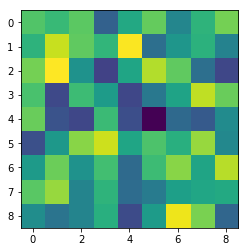

In [8]:
##------ Add your code here: try to visualise variables (w1, w2, w3)
# height, width, number of channels, reshape using numpy
# visualise the model loaded
v1 = model['w1'].reshape(9,9,64)
v2 = model['w2'].reshape(1, 1, 2048)
v3 = model['w3'].reshape(5, 5, 32)

# v1 is 3 dimension, take all of 1st dimension, all of 2nd dimension
for i in range(v1.shape[2]):
    plt.subplot
    plt.imshow(v1[:,:,i])
plt.show()

In [9]:
np.squeeze(model['w1'][:,:,:,0])

array([[-0.01077257, -0.00336509,  0.00544545,  0.01578573,  0.01743072,
         0.01199636,  0.0034335 , -0.00591595, -0.01570142],
       [-0.01289676, -0.01250388,  0.0001481 ,  0.01255877,  0.01715461,
         0.01009237,  0.00546394, -0.00217959, -0.01070087],
       [-0.01064688, -0.01051157, -0.00589617,  0.00597999,  0.01223843,
         0.00853102,  0.00628482,  0.00174211, -0.00752197],
       [-0.00721352, -0.01198767, -0.01012878,  0.00178361,  0.00748584,
         0.00723962,  0.00514654,  0.00235108, -0.00246841],
       [ 0.0002735 , -0.00970723, -0.01081259, -0.00557329,  0.0011969 ,
         0.0052124 ,  0.00695516,  0.00680155,  0.00132568],
       [ 0.00070515, -0.00490749, -0.01100177, -0.00988301, -0.00479379,
         0.00386728,  0.00934407,  0.00816753,  0.00656106],
       [ 0.00620539, -0.0030037 , -0.00933842, -0.0137797 , -0.00878054,
        -0.00248042,  0.00475708,  0.00937654,  0.0094001 ],
       [ 0.01097434,  0.00117022, -0.0086742 , -0.01293966, -0

In [10]:
"""Initialize the model variabiles (w1, w2, w3, b1, b2, b3) with the pre-trained model file
"""
# launch a session
sess = tf.Session()

for key in weights.keys():
  sess.run(weights[key].assign(model[key]))

for key in biases.keys():
  sess.run(biases[key].assign(model[key]))

"""Read the test image
"""
blurred_image, groundtruth_image = preprocess('./butterfly_GT.bmp')

"""Run the model and get the SR image
"""
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(blurred_image, axis =0), axis=-1)

# run the session
# here you can also run to get feature map like 'conv1' and 'conv2'
ouput_ = sess.run(conv3, feed_dict={inputs: input_})

In [20]:
ouput_.shape

(1, 243, 243, 1)

In [32]:
##------ Add your code here: save the blurred and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.meause.compare_psnr()'
# imsave is deprecated! imsave is deprecated in SciPy 1.0.0, and will be removed in 1.2.0. Use imageio.imwrite instea
scipy.misc.imsave('blurred.bmp', blurred_image)
scipy.misc.imsave('groundtruth.bmp', groundtruth_image)
scipy.misc.imsave('output.jpg', ouput_[0,:,:,0])

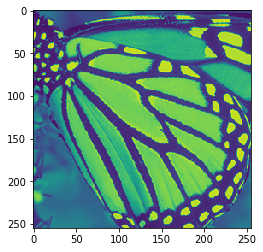

In [33]:
plt.imshow(groundtruth_image)

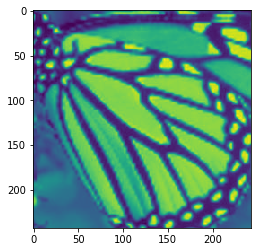

In [34]:
a = scipy.misc.imread('output.jpg')
plt.imshow(a)
#plt.show(a)

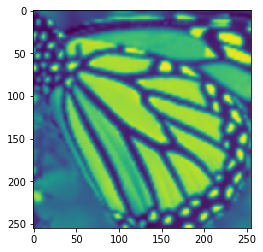

In [35]:
plt.imshow(blurred_image)

In [36]:
from skimage import data, io, filters
import numpy, math
##------ Add your code here: save the blurred and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.measure.compare_psnr()' - did not work

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

psnr(blurred_image, groundtruth_image)

68.62843378196472